In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('drive/My Drive/FORMATION_DATASCIENCE_suite_P7/Projet 7/notebooks/home_credit_data/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

# modeling
import lightgbm as lgb

# utilities
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

plt.style.use('fivethirtyeight')

# Memory management
import gc

# Introduction: Manual Feature Engineering (part two)

In this notebook we will expand on the [Introduction to Manual Feature Engineering](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering/output) notebook. We will use the aggregation and value counting functions developed in that notebook in order to incorporate information from the `previous_application`, `POS_CASH_balance`, `installments_payments`, and `credit_card_balance` data files. We already used the information from the `bureau` and `bureau_balance` in the previous notebook and were able to improve our competition score compared to using only the `application` data. After running a model with the features included here, performance does increase, but we run into issues with an explosion in the number of features! I'm working on a notebook of feature selection, but for this notebook we will continue building up a rich set of data for our model.

The definitions of the four additional data files are:

* previous_application (called `previous`): previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.
* POS_CASH_BALANCE (called `cash`): monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
* credit_card_balance (called `credit`): monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
* installments_payment (called `installments`): payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.

# Functions

We spent quite a bit of time developing two functions in the previous notebook:

* `agg_numeric`: calculate aggregation statistics (`mean`, `count`, `max`, `min`) for numeric variables.
* `agg_categorical`: compute counts and normalized counts of each category in a categorical variable.

Together, these two functions can extract information about both the numeric and categorical data in a dataframe. Our general approach will be to apply both of these functions to the dataframes, grouping by the client id, `SK_ID_CURR`. For the `POS_CASH_balance`, `credit_card_balance`, and `installment_payments`, we can first group by the `SK_ID_PREV`, the unique id for the previous loan. Then we will group the resulting dataframe by the `SK_ID_CURR` to calculate the aggregation statistics for each client across all of their previous loans. If that's a little confusing, I'd suggest heading back to the [first feature engineering notebook](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering/output).**

### Function to Aggregate Numeric Data

This groups data by the `group_var` and calculates `mean`, `max`, `min`, and `sum`. It will only be applied to numeric data by default in pandas.

In [ ]:
def agg_numeric(df, parent_var, df_name):
    """
    Groups and aggregates the numeric values in a child dataframe
    by the parent variable.

    Parameters
    --------
        df (dataframe):
            the child dataframe to calculate the statistics on
        parent_var (string):
            the parent variable used for grouping and aggregating
        df_name (string):
            the variable used to rename the columns

    Return
    --------
        agg (dataframe):
            a dataframe with the statistics aggregated by the `parent_var` for
            all numeric columns. Each observation of the parent variable will have
            one row in the dataframe with the parent variable as the index.
            The columns are also renamed using the `df_name`. Columns with all duplicate
            values are removed.

    """

    # Remove id variables other than grouping variable
    for col in df:
        if col != parent_var and 'SK_ID' in col:
            df = df.drop(columns = col)

    # Only want the numeric variables
    parent_ids = df[parent_var].copy()
    numeric_df = df.select_dtypes('number').copy()
    numeric_df[parent_var] = parent_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(parent_var).agg(['count', 'mean', 'max', 'min', 'sum'])

    # Need to create new column names
    columns = []

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        if var != parent_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns

    # Remove the columns with all redundant values
    _, idx = np.unique(agg, axis = 1, return_index=True)
    agg = agg.iloc[:, idx]

    return agg

### Function to Calculate Categorical Counts

This function calculates the occurrences (counts) of each category in a categorical variable for each client. It also calculates the normed count, which is the count for a category divided by the total counts for all categories in a categorical variable.

In [ ]:
def agg_categorical(df, parent_var, df_name):
    """
    Aggregates the categorical features in a child dataframe
    for each observation of the parent variable.

    Parameters
    --------
    df : dataframe
        The dataframe to calculate the value counts for.

    parent_var : string
        The variable by which to group and aggregate the dataframe. For each unique
        value of this variable, the final dataframe will have one row

    df_name : string
        Variable added to the front of column names to keep track of columns


    Return
    --------
    categorical : dataframe
        A dataframe with aggregated statistics for each observation of the parent_var
        The columns are also renamed and columns with duplicate values are removed.

    """

    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('category'))

    # Make sure to put the identifying id on the column
    categorical[parent_var] = df[parent_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(parent_var).agg(['sum', 'count', 'mean'])

    column_names = []

    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['sum', 'count', 'mean']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))

    categorical.columns = column_names

    # Remove duplicate columns by values
    _, idx = np.unique(categorical, axis = 1, return_index = True)
    categorical = categorical.iloc[:, idx]

    return categorical

### Function for KDE Plots of Variable

We also made a function that plots the distribution of variable colored by the value of `TARGET` (either 1 for did not repay the loan or 0 for did repay the loan). We can use this function to visually examine any new variables we create. This also calculates the correlation cofficient of the variable with the target which can be used as an approximation of whether or not the created variable will be useful.

In [ ]:
# Plots the disribution of a variable colored by value of the target
def kde_target(var_name, df):

    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])

    # Calculate medians for repaid vs not repaid
    avg_repaid = df.ix[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.ix[df['TARGET'] == 1, var_name].median()

    plt.figure(figsize = (12, 6))

    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.ix[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.ix[df['TARGET'] == 1, var_name], label = 'TARGET == 1')

    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();

    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)


## Function to Convert Data Types

This will help reduce memory usage by using more efficient types for the variables. For example `category` is often a better type than `object` (unless the number of unique categories is close to the number of rows in the dataframe).

In [ ]:
import sys

def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):

    original_memory = df.memory_usage().sum()

    # Iterate through each column
    for c in df:

        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)

        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')

        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)

        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)

        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)

    new_memory = df.memory_usage().sum()

    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')

    return df

Let's deal with one dataframe at a time. First up is the `previous_applications`. This has one row for every previous loan a client had at Home Credit. A client can have multiple previous loans which is why we need to aggregate statistics for each client.

## Function to remove colinear features

In [ ]:
from tqdm import tqdm
def evaluate_colinear(df, threshold=0.9):
    # --------------------
    # df --> to analyse
    # Threshold --> each couple of feature correlated above this value will be shown

    # ==> return dataframe sorted containing features correlations
    # --------------------

    # Absolute value correlation matrix
    corr_matrix = df.corr().abs()

    # Upper triangle of correlations
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

    # Select columns with correlations above threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    max_corr = [upper[column].max() for column in to_drop] # valeur de la plus grande correlation
    feat_max_corr = [upper[column].index[np.where(upper[column] == upper[column].max())[0][0]] for column in tqdm(to_drop)] # feature correspondante au max

    corr_table = pd.DataFrame({"features A" : to_drop,
                              "features B" : feat_max_corr,
                                "correlation coefficient" : max_corr})

    duo_to_drop = corr_table['features B'].unique()

    print('There are %d columns to remove' % (len(duo_to_drop)), ' among the %d columns.' % (df.shape[1]))

    return corr_table, duo_to_drop

In [ ]:
def drop_colinear(train, test, threshold=0.9):
    # --------------------
    # train --> train dataset
    # test --> test dataset
    # Threshold --> for removing correlated variables
    # --------------------

    # Absolute value correlation matrix
    corr_matrix = train.corr().abs()

    # Upper triangle of correlations
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

    # Select columns with correlations above threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    print('There are %d columns to remove' % (len(to_drop)), ' among the %d columns.' % (train.shape[1]))

    train = train.drop(columns = to_drop)

    # alignement en colonnes des deux tables
    labels = train.TARGET
    train, test = train.drop('TARGET', axis=1).align(test, join = 'inner', axis = 1)

    # add the target
    train['TARGET'] = labels

    print('Training new shape: ', train.shape)
    print('Testing new shape: ', test.shape)

    return train, test

## Function to remove big missing values features

In [ ]:
def drop_missing_val_features(train, test, threshold=0.75):
    # --------------------
    # train --> train dataset
    # test --> test dataset
    # Threshold --> for removing variables based on missing values rate
    # --------------------

    # do on train
    A = train.isna().mean()
    to_drop = list(A[A >= threshold].index)
    print(f'{len(to_drop)} columns have more than {threshold}% of missing values in TRAIN dataset and are suppressed.')
    train = train.drop(to_drop, axis=1)

    # do on test
    A = test.isna().mean()
    to_drop = list(A[A >= threshold].index)
    print(f'{len(to_drop)} columns have more than {threshold}% of missing values in TEST dataset and are suppressed.')
    test = test.drop(to_drop, axis=1)

    # alignement en colonnes des deux tables
    labels = train.TARGET
    train, test = train.drop('TARGET', axis=1).align(test, join = 'inner', axis = 1)
    # add the target
    train['TARGET'] = labels

    print('Training new shape: ', train.shape)
    print('Testing new shape: ', test.shape)

    return train, test

# Treatment One

## app_train and app_test first treatment

In [ ]:
# Read in new copies of all the dataframes
app_train = pd.read_csv('application_train.csv')
app_test = pd.read_csv('application_test.csv')

In [ ]:
print(app_train.shape)
print(app_test.shape)

(307511, 122)
(48744, 121)


In [ ]:
app_train = convert_types(app_train, print_info = True)

Original Memory Usage: 0.3 gb.
New Memory Usage: 0.13 gb.


In [ ]:
app_test = convert_types(app_test, print_info = True)

Original Memory Usage: 0.05 gb.
New Memory Usage: 0.02 gb.


In [ ]:
# transforme features numeriques et categorielles
app_train_counts = agg_categorical(app_train.drop(columns = ['TARGET']), parent_var = 'SK_ID_CURR', df_name = 'application')
app_train_agg = agg_numeric(app_train.drop(columns = ['TARGET']), parent_var = 'SK_ID_CURR', df_name = 'application')

# merge le tout
app_train = app_train.merge(app_train_counts, on = 'SK_ID_CURR', how = 'left')
app_train = app_train.merge(app_train_agg, on = 'SK_ID_CURR', how = 'left')
app_train.shape

(307511, 571)

In [ ]:
# Remove variables to free memory
gc.enable()
del app_train_counts, app_train_agg
gc.collect()

0

In [ ]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,application_AMT_ANNUITY_min,application_AMT_INCOME_TOTAL_mean,application_AMT_GOODS_PRICE_sum,application_AMT_GOODS_PRICE_mean,application_AMT_GOODS_PRICE_max,application_AMT_GOODS_PRICE_min,application_AMT_CREDIT_mean,application_OWN_CAR_AGE_mean,application_OWN_CAR_AGE_max,application_OWN_CAR_AGE_min
0,100002,True,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,24700.5,202500.0,351000.0,351000.0,351000.0,351000.0,406597.5,NaN,NaN,NaN
1,100003,False,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,35698.5,270000.0,1129500.0,1129500.0,1129500.0,1129500.0,1293502.5,NaN,NaN,NaN
2,100004,False,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,6750.0,67500.0,135000.0,135000.0,135000.0,135000.0,135000.0,26.0,26.0,26.0
3,100006,False,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,29686.5,135000.0,297000.0,297000.0,297000.0,297000.0,312682.5,NaN,NaN,NaN
4,100007,False,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,21865.5,121500.0,513000.0,513000.0,513000.0,513000.0,513000.0,NaN,NaN,NaN


In [ ]:
# transforme features numeriques et categorielles pour la table de test
app_test_counts = agg_categorical(app_test, parent_var = 'SK_ID_CURR', df_name = 'application')
app_test_agg = agg_numeric(app_test, parent_var = 'SK_ID_CURR', df_name = 'application')

# merge le tout
app_test = app_test.merge(app_test_counts, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(app_test_agg, on = 'SK_ID_CURR', how = 'left')
app_test.shape

(48744, 545)

In [ ]:
# Remove variables to free memory
gc.enable()
del app_test_counts, app_test_agg
gc.collect()

0

In [ ]:
# alignement en colonnes des deux tables
labels = app_train.TARGET
app_train = app_train.drop('TARGET', axis=1)
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)
app_train['TARGET'] = labels
print(app_train.shape)
print(app_test.shape)
print(app_train.shape)
print(app_test.shape)

(307511, 545)
(48744, 544)
(307511, 545)
(48744, 544)


In [ ]:
# export de ce premier traitement
app_train.to_csv('FEATURE_ENG/app_train_counts_agg.csv', index=False)
app_test.to_csv('FEATURE_ENG/app_test_counts_agg.csv', index=False)

In [ ]:
# app_train = pd.read_csv('FEATURE_ENG/app_train_counts_agg.csv')
# app_test = pd.read_csv('FEATURE_ENG/app_test_counts_agg.csv')

## Feature Engineering

Kaggle competitions are won by feature engineering: those win are those who can create the most useful features out of the data. (This is true for the most part as the winning models, at least for structured data, all tend to be variants on [gradient boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)). This represents one of the patterns in machine learning: feature engineering has a greater return on investment than model building and hyperparameter tuning. [This is a great article on the subject)](https://www.featurelabs.com/blog/secret-to-data-science-success/). As Andrew Ng is fond of saying: "applied machine learning is basically feature engineering."

While choosing the right model and optimal settings are important, the model can only learn from the data it is given. Making sure this data is as relevant to the task as possible is the job of the data scientist (and maybe some [automated tools](https://docs.featuretools.com/getting_started/install.html) to help us out).

Feature engineering refers to a geneal process and can involve both feature construction: adding new features from the existing data, and feature selection: choosing only the most important features or other methods of dimensionality reduction. There are many techniques we can use to both create features and select features.

We will do a lot of feature engineering when we start using the other data sources, but in this notebook we will try only two simple feature construction methods:

* Polynomial features
* Domain knowledge features


### Polynomial Features

One simple feature construction method is called [polynomial features](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html). In this method, we make features that are powers of existing features as well as interaction terms between existing features. For example, we can create variables `EXT_SOURCE_1^2` and `EXT_SOURCE_2^2` and also variables such as `EXT_SOURCE_1` x `EXT_SOURCE_2`, `EXT_SOURCE_1` x `EXT_SOURCE_2^2`, `EXT_SOURCE_1^2` x   `EXT_SOURCE_2^2`, and so on. These features that are a combination of multiple individual variables are called [interaction terms](https://en.wikipedia.org/wiki/Interaction_(statistics) because they  capture the interactions between variables. In other words, while two variables by themselves  may not have a strong influence on the target, combining them together into a single interaction variable might show a relationship with the target. [Interaction terms are commonly used in statistical models](https://www.theanalysisfactor.com/interpreting-interactions-in-regression/) to capture the effects of multiple variables, but I do not see them used as often in machine learning. Nonetheless, we can try out a few to see if they might help our model to predict whether or not a client will repay a loan.

Jake VanderPlas writes about [polynomial features in his excellent book Python for Data Science](https://jakevdp.github.io/PythonDataScienceHandbook/05.04-feature-engineering.html) for those who want more information.

In the following code, we create polynomial features using the `EXT_SOURCE` variables and the `DAYS_BIRTH` variable. [Scikit-Learn has a useful class called `PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) that creates the polynomials and the interaction terms up to a specified degree. We can use a degree of 3 to see the results (when we are creating polynomial features, we want to avoid using too high of a degree, both because the number of features scales exponentially with the degree, and because we can run into [problems with overfitting](http://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html#sphx-glr-auto-examples-model-selection-plot-underfitting-overfitting-py)).

In [ ]:
# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
# from sklearn.preprocessing import Imputer --> deprecated
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures

# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [ ]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


This creates a considerable number of new features. To get the names we have to use the polynomial features `get_feature_names` method.

In [ ]:
poly_transformer.get_feature_names_out(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

array(['1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2',
       'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_1 DAYS_BIRTH',
       'EXT_SOURCE_2^2', 'EXT_SOURCE_2 EXT_SOURCE_3',
       'EXT_SOURCE_2 DAYS_BIRTH', 'EXT_SOURCE_3^2',
       'EXT_SOURCE_3 DAYS_BIRTH', 'DAYS_BIRTH^2'], dtype=object)

There are 35 features with individual features raised to powers up to degree 3 and interaction terms. Now, we can see whether any of these new features are correlated with the target.

In [ ]:
# Create a dataframe of the features
poly_features = pd.DataFrame(poly_features,
                             columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2',
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
EXT_SOURCE_3                             -0.155892
EXT_SOURCE_1 EXT_SOURCE_3^2              -0.150822
Name: TARGET, dtype: float64
EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH    0.155891
EXT_SOURCE_2 DAYS_BIRTH                 0.156873
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH    0.181283
TARGET                                  1.000000
1                                            NaN
Name: TARGET, dtype: float64


Several of the new variables have a greater (in terms of absolute magnitude) correlation with the target than the original features. When we build machine learning models, we can try with and without these features to determine if they actually help the model learn.

We will add these features to a copy of the training and testing data and then evaluate models with and without the features. Many times in machine learning, the only way to know if an approach will work is to try it out!

In [ ]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test,
                                  columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2',
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
poly_features = poly_features.drop(['TARGET'], axis=1)
app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
labels = app_train_poly['TARGET']
app_train_poly = app_train_poly.drop(columns = ['TARGET'], axis=1)
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)
app_train_poly['TARGET'] = labels

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

Training data with polynomial features shape:  (307511, 580)
Testing data with polynomial features shape:   (48744, 579)


In [ ]:
# Remove variables to free memory
gc.enable()
del poly_features, poly_features_test, poly_target, labels
gc.collect()

In [ ]:
# export de ce second traitement
app_train_poly.to_csv('FEATURE_ENG/app_train_poly.csv', index=False)
app_test_poly.to_csv('FEATURE_ENG/app_test_poly.csv', index=False)

In [ ]:
# app_train_poly = pd.read_csv('FEATURE_ENG/app_train_poly.csv')
# app_test_poly = pd.read_csv('FEATURE_ENG/app_test_poly.csv')

### Domain Knowledge Features

Maybe it's not entirely correct to call this "domain knowledge" because I'm not a credit expert, but perhaps we could call this "attempts at applying limited financial knowledge". In this frame of mind, we can make a couple features that attempt to capture what we think may be important for telling whether a client will default on a loan. Here I'm going to use five features that were inspired by [this script](https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) by Aguiar:

* `CREDIT_INCOME_PERCENT`: the percentage of the credit amount relative to a client's income
* `ANNUITY_INCOME_PERCENT`: the percentage of the loan annuity relative to a client's income
* `CREDIT_TERM`:  the length of the payment in months (since the annuity is the monthly amount due
* `DAYS_EMPLOYED_PERCENT`: the percentage of the days employed relative to the client's age

Again, thanks to Aguiar and [his great script](https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) for exploring these features.



In [ ]:
#app_train_poly = pd.read_csv('FEATURE_ENG/app_train_poly.csv')
#app_test_poly = pd.read_csv('FEATURE_ENG/app_test_poly.csv')

In [ ]:
#app_train = pd.read_csv('application_train.csv')
#app_test = pd.read_csv('application_test.csv')

In [ ]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [ ]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

In [ ]:
app_train_knowledge = app_train_poly.copy()
app_train_knowledge['CREDIT_INCOME_PERCENT'] = app_train_domain['CREDIT_INCOME_PERCENT']
app_train_knowledge['ANNUITY_INCOME_PERCENT'] = app_train_domain['ANNUITY_INCOME_PERCENT']
app_train_knowledge['CREDIT_TERM'] = app_train_domain['CREDIT_TERM']
app_train_knowledge['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED_PERCENT']

In [ ]:
app_test_knowledge = app_test_poly.copy()
app_test_knowledge['CREDIT_INCOME_PERCENT'] = app_test_domain['CREDIT_INCOME_PERCENT']
app_test_knowledge['ANNUITY_INCOME_PERCENT'] = app_test_domain['ANNUITY_INCOME_PERCENT']
app_test_knowledge['CREDIT_TERM'] = app_test_domain['CREDIT_TERM']
app_test_knowledge['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED_PERCENT']

In [ ]:
# export de ce second traitement
app_train_domain.to_csv('FEATURE_ENG/app_train_knowledge.csv', index=False)
app_test_domain.to_csv('FEATURE_ENG/app_test_knowledge.csv', index=False)

In [ ]:
# app_train_domain = pd.read_csv('FEATURE_ENG/app_train_knowledge.csv')
# app_test_domain = pd.read_csv('FEATURE_ENG/app_test_knowledge.csv')

#### Visualize New Variables

We should explore these __domain knowledge__ variables visually in a graph. For all of these, we will make the same KDE plot colored by the value of the `TARGET`.

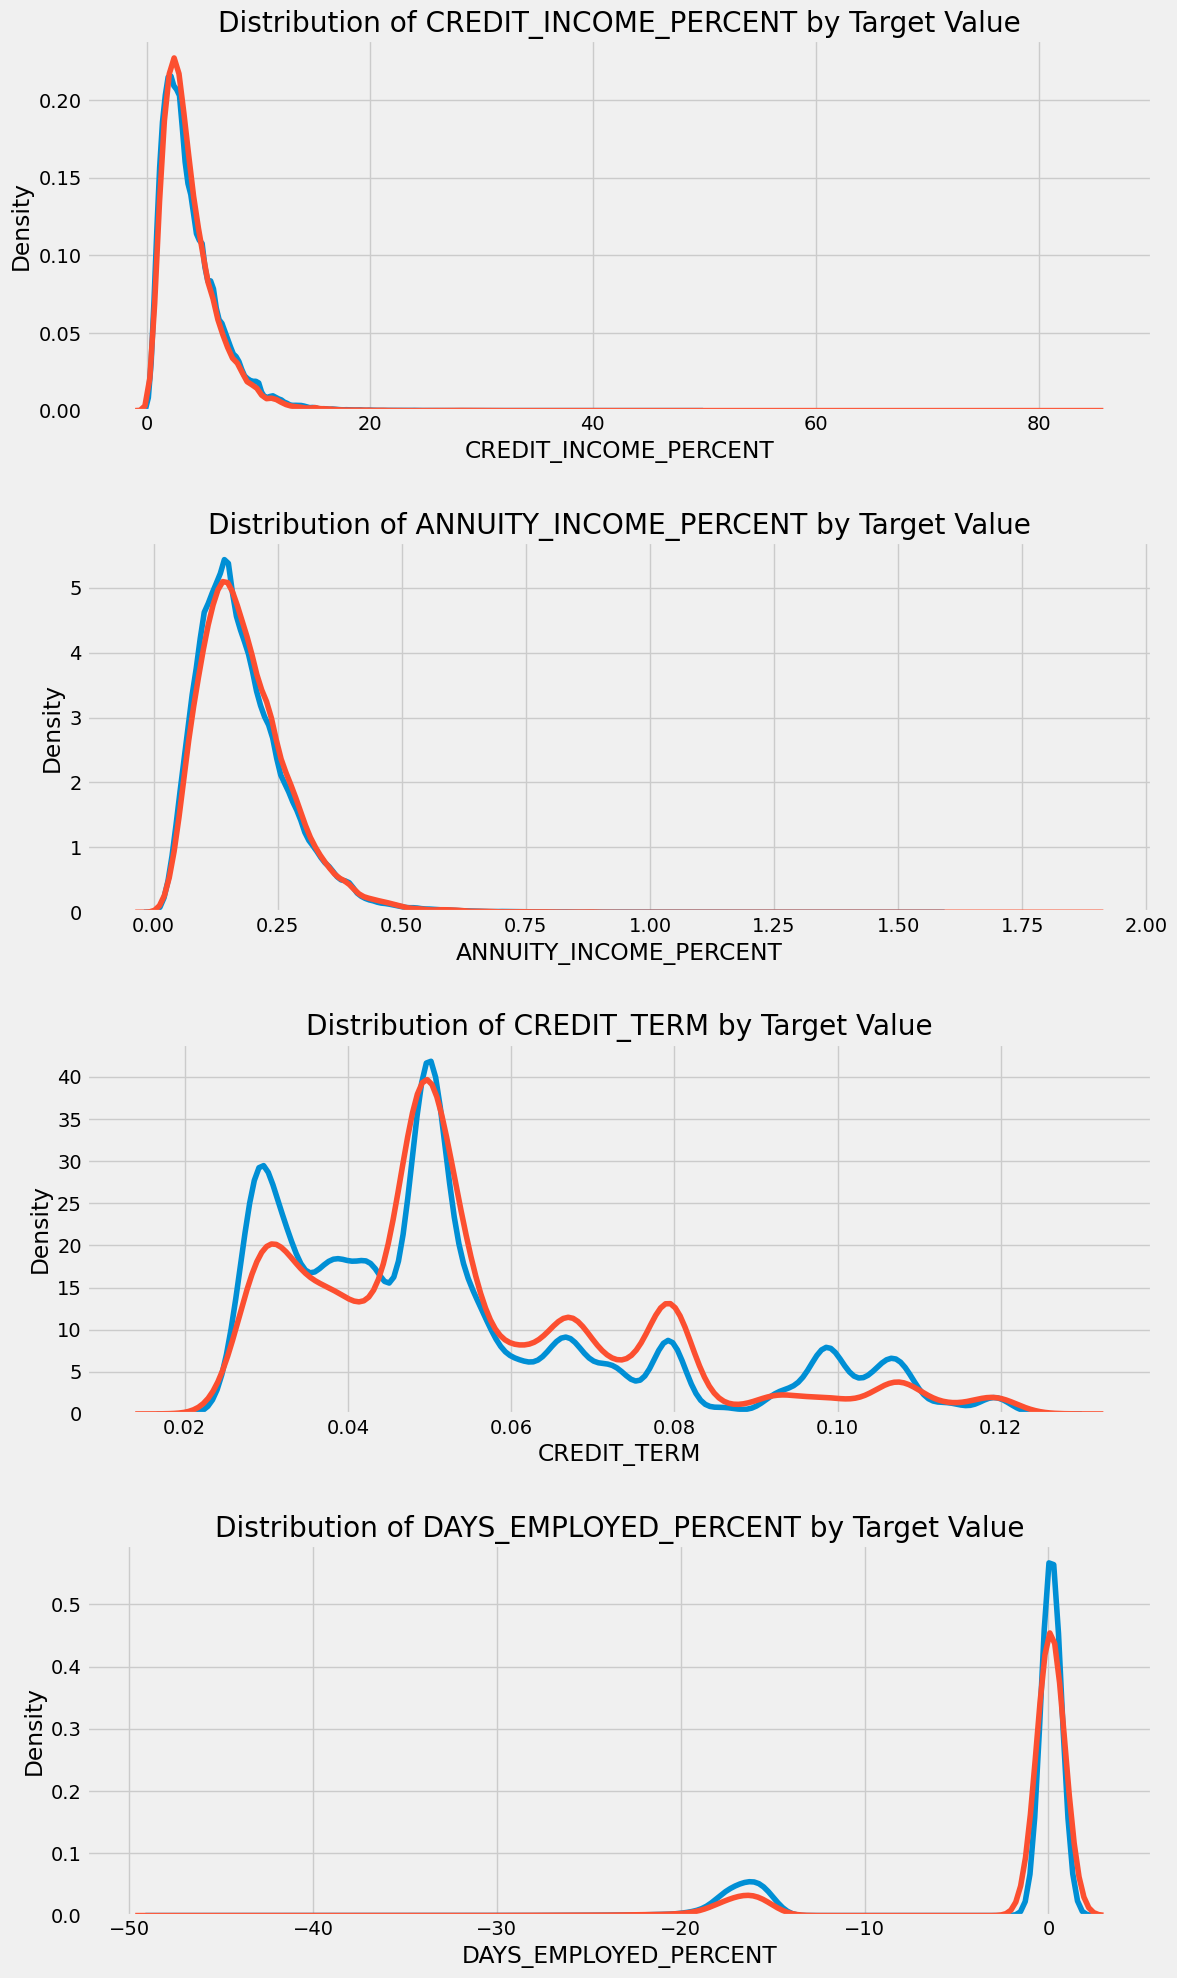

In [ ]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):

    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')

    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');

plt.tight_layout(h_pad = 2.5)

It's hard to say ahead of time if these new features will be useful. The only way to tell for sure is to try them out!

## bureau

In [ ]:
# Read in new copies of all the dataframes
# train = pd.read_csv('application_train.csv')
bureau = pd.read_csv('bureau.csv')
bureau_balance = pd.read_csv('bureau_balance.csv')

In [ ]:
print(bureau.shape)
print(bureau_balance.shape)

(1716428, 17)
(27299925, 3)


In [ ]:
bureau = convert_types(bureau, print_info = True)
bureau_balance = convert_types(bureau_balance, print_info = True)

Original Memory Usage: 0.23 gb.
New Memory Usage: 0.1 gb.
Original Memory Usage: 0.66 gb.
New Memory Usage: 0.25 gb.


### Counts of Bureau Dataframe

In [ ]:
bureau_counts = agg_categorical(bureau, parent_var = 'SK_ID_CURR', df_name = 'bureau')
# bureau_counts.head()

### Aggregated Stats of Bureau Dataframe

In [ ]:
bureau_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), parent_var = 'SK_ID_CURR', df_name = 'bureau')
# bureau_agg.head()

### Value counts of Bureau Balance dataframe by loan

In [ ]:
bureau_balance_counts = agg_categorical(bureau_balance, parent_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
# bureau_balance_counts.head()

### Aggregated stats of Bureau Balance dataframe by loan

In [ ]:
bureau_balance_agg = agg_numeric(bureau_balance, parent_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
# bureau_balance_agg.head()

### Aggregated Stats of Bureau Balance by Client

In [ ]:
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left')

# Aggregate the stats for each client
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), parent_var = 'SK_ID_CURR', df_name = 'client')

In [ ]:
# nouvelle variable pour le dataset de application + données externe à home credit
train_extern = app_train_knowledge.copy()

In [ ]:
original_features = list(train_extern.columns)
print('Original Number of Features: ', len(original_features))

Original Number of Features:  584


In [ ]:
# Merge with the value counts of bureau
train_extern = train_extern.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
train_extern = train_extern.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the monthly information grouped by client
train_extern = train_extern.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [ ]:
new_features = list(train_extern.columns)
print('Number of features using previous loans from other institutions data: ', len(new_features))

Number of features using previous loans from other institutions data:  775


In [ ]:
# do the same on test and align
test_extern = app_test_knowledge.copy()
print('Original Number of Features in test : ', len(test_extern.columns))

# Merge with the value counts of bureau
test_extern = test_extern.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
test_extern = test_extern.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the monthly information grouped by client
test_extern = test_extern.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

print('New Number of Features in test : ', len(test_extern.columns))

Original Number of Features in test :  583
New Number of Features in test :  774


In [ ]:
# Align the dataframes
labels = train_extern['TARGET']
train_extern = train_extern.drop(columns = ['TARGET'], axis=1)
train_extern, test_extern = train_extern.align(test_extern, join = 'inner', axis = 1)
train_extern['TARGET'] = labels

# Print out the new shapes
print('Training data shape: ', train_extern.shape)
print('Testing data shape:  ', test_extern.shape)

Training data shape:  (307511, 775)
Testing data shape:   (48744, 774)


In [ ]:
# Remove variables to free memory
gc.enable()
del bureau_by_loan, bureau_balance_by_client, bureau_balance_agg, bureau_balance_counts, bureau_agg, bureau_counts, labels
gc.collect()

5

In [ ]:
# export de ce second traitement
train_extern.to_csv('FEATURE_ENG/train_extern.csv', index=False)
test_extern.to_csv('FEATURE_ENG/test_extern.csv', index=False)

In [ ]:
train_extern = pd.read_csv('FEATURE_ENG/train_extern.csv')
test_extern = pd.read_csv('FEATURE_ENG/test_extern.csv')

## Function to Calculate Missing Values

In [ ]:
# Function to calculate missing values by column# Funct
def missing_values_table(df, print_info = False, threshold = 75):
        # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        if print_info:
            # Print some summary information
            print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
                "There are " + str(mis_val_table_ren_columns.shape[0]) +
                  " columns that have missing values.")

            print ("There are " + str(mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] >= 75].shape[0]) +
                  " columns that have more than " + str(threshold) + " missing values.")

        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [ ]:
def remove_missing_columns(train, test, threshold = 90):
    # Calculate missing stats for train and test (remember to calculate a percent!)
    train_miss = pd.DataFrame(train.isnull().sum())
    train_miss['percent'] = 100 * train_miss[0] / len(train)

    test_miss = pd.DataFrame(test.isnull().sum())
    test_miss['percent'] = 100 * test_miss[0] / len(test)

    # list of missing columns for train and test
    missing_train_columns = list(train_miss.index[train_miss['percent'] > threshold])
    missing_test_columns = list(test_miss.index[test_miss['percent'] > threshold])

    # Combine the two lists together
    missing_columns = list(set(missing_train_columns + missing_test_columns))

    # Print information
    print('There are %d columns with greater than %d%% missing values.' % (len(missing_columns), threshold))

    # Drop the missing columns and return
    train = train.drop(columns = missing_columns)
    test = test.drop(columns = missing_columns)

    return train, test

In [ ]:
train_extern.dtypes

SK_ID_CURR                                          int64
NAME_CONTRACT_TYPE                                 object
CODE_GENDER                                        object
FLAG_OWN_CAR                                       object
FLAG_OWN_REALTY                                    object
                                                   ...   
client_bureau_balance_MONTHS_BALANCE_count_max    float64
client_bureau_balance_STATUS_0_count_max          float64
client_bureau_balance_STATUS_C_sum_sum            float64
client_bureau_balance_MONTHS_BALANCE_count_sum    float64
TARGET                                               bool
Length: 775, dtype: object

In [ ]:
# j'ai par erreur conservé les colonnes textuelles, je vais donc les supprimer (16)
train_extern = train_extern.drop(train_extern.select_dtypes('object').columns, axis=1)

In [ ]:
train_extern.shape

(307511, 759)

In [ ]:
train_extern_2 = train_extern.copy()

In [ ]:
mis_val_table_ren_columns = missing_values_table(train_extern_2, print_info = True)
mis_val_table_ren_columns

Your selected dataframe has 759 columns.
There are 431 columns that have missing values.
There are 0 columns that have more than 75 missing values.


,Missing Values,% of Total Values
bureau_AMT_ANNUITY_max,227502,74.0
bureau_AMT_ANNUITY_mean,227502,74.0
bureau_AMT_ANNUITY_min,227502,74.0
client_bureau_balance_STATUS_5_mean_mean,215280,70.0
client_bureau_balance_STATUS_3_mean_max,215280,70.0
...,...,...
AMT_ANNUITY,12,0.0
application_CNT_FAM_MEMBERS_mean,2,0.0
CNT_FAM_MEMBERS,2,0.0
application_DAYS_LAST_PHONE_CHANGE_mean,1,0.0


In [ ]:
mis_val_table_ren_columns.loc[mis_val_table_ren_columns["% of Total Values"]>=60,:]

,Missing Values,% of Total Values
bureau_AMT_ANNUITY_max,227502,74.0
bureau_AMT_ANNUITY_mean,227502,74.0
bureau_AMT_ANNUITY_min,227502,74.0
client_bureau_balance_STATUS_5_mean_mean,215280,70.0
client_bureau_balance_STATUS_3_mean_max,215280,70.0
...,...,...
application_YEARS_BUILD_AVG_min,204488,66.5
application_OWN_CAR_AGE_min,202929,66.0
application_OWN_CAR_AGE_max,202929,66.0
application_OWN_CAR_AGE_mean,202929,66.0


In [ ]:
# je vais supprimer les colonnes avec plus de 60% de valeurs manquantes (133)
drop_miss = mis_val_table_ren_columns.loc[mis_val_table_ren_columns["% of Total Values"]>=60,:].index.tolist()
train_extern_2 = train_extern_2.drop(drop_miss, axis=1)
print("New colomns number : ", train_extern_2.shape[1])

New colomns number :  626


In [ ]:
# miantenant je regarde cb de colonnes fortement colinéaire je peut retirer
corr_table, drop_corr = evaluate_colinear(train_extern_2, threshold=0.9)
corr_table

100%|██████████| 303/303 [00:00<00:00, 2800.70it/s]

There are 123 columns to remove  among the 626 columns.


,features A,features B,correlation coefficient
0,AMT_GOODS_PRICE,AMT_CREDIT,0.986968
1,FLAG_EMP_PHONE,DAYS_EMPLOYED,0.999755
2,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,0.950842
3,LIVINGAREA_AVG,APARTMENTS_AVG,0.913619
4,APARTMENTS_MODE,APARTMENTS_AVG,0.973259
...,...,...,...
298,client_bureau_balance_MONTHS_BALANCE_min_sum,client_bureau_balance_MONTHS_BALANCE_sum_sum,0.943504
299,client_bureau_balance_MONTHS_BALANCE_mean_sum,client_bureau_balance_MONTHS_BALANCE_min_sum,0.982719
300,client_bureau_balance_MONTHS_BALANCE_sum_count,client_bureau_balance_MONTHS_BALANCE_min_sum,0.930227
301,client_bureau_balance_STATUS_C_sum_sum,client_bureau_balance_STATUS_C_mean_sum,0.911103


In [ ]:
# suppression des features corrélées à plus de 0.9
train_extern_2 = train_extern_2.drop(drop_corr, axis=1)
print('nombre de colonnes restantes après suppression des features corrélées : ' + str(train_extern_2.shape[1]))

nombre de colonnes restantes après suppression des features corrélées : 503


In [ ]:
# export de ce traitement
train_extern_2.to_csv('FEATURE_ENG/train_extern_2.csv', index=False)

In [ ]:
# alignement avec test
# Align the dataframes
test_extern_2 = test_extern.copy()

print('Nombre de colonnes initial du test :', test_extern_2.shape[1])
labels = train_extern_2['TARGET']
train_extern_2 = train_extern_2.drop(columns = ['TARGET'], axis=1)
train_extern_2, test_extern_2 = train_extern_2.align(test_extern_2, join = 'inner', axis = 1)
train_extern_2['TARGET'] = labels
print('Nouveau nombre de colonnes du test :', test_extern_2.shape[1])


Nombre de colonnes initial du test : 774
Nouveau nombre de colonnes du test : 502


In [ ]:
# export de ce second traitement
train_extern_2.to_csv('FEATURE_ENG/train_extern_2.csv', index=False)
test_extern_2.to_csv('FEATURE_ENG/test_extern_2.csv', index=False)

In [ ]:
# Remove variables to free memory
gc.enable()
del corr_table, drop_corr, drop_miss, mis_val_table_ren_columns, train_extern, test_extern
gc.collect()

17

## previous

### previous_application

In [ ]:
previous = pd.read_csv('previous_application.csv')
previous = convert_types(previous, print_info=True)
#previous.head()

Original Memory Usage: 0.49 gb.
New Memory Usage: 0.16 gb.


In [ ]:
# Calculate aggregate statistics for each numeric column
previous_agg = agg_numeric(previous, 'SK_ID_CURR', 'previous')
print('Previous aggregation shape: ', previous_agg.shape)
#previous_agg.head()

Previous aggregation shape:  (338857, 80)


In [ ]:
# Calculate value counts for each categorical column
previous_counts = agg_categorical(previous, 'SK_ID_CURR', 'previous')
print('Previous counts shape: ', previous_counts.shape)
#previous_counts.head()

Previous counts shape:  (338857, 285)


We can join the calculated dataframe to the main training dataframe using a merge. Then we should delete the calculated dataframes to avoid using too much of the kernel memory.

In [ ]:
#train = pd.read_csv('application_train.csv')
#train = convert_types(train)
#test = pd.read_csv('application_test.csv')
#test = convert_types(test)

train_previous = train_extern_2.copy()
test_previous = test_extern_2.copy()

# Merge in the previous information
train_previous = train_previous.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
train_previous = train_previous.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

test_previous = test_previous.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
test_previous = test_previous.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

# Remove variables to free memory
gc.enable()
del previous, previous_agg, previous_counts
gc.collect()

0

In [ ]:
# Remove variables to free memory
gc.enable()
del train_extern_2, test_extern_2
gc.collect()

90

### Dimentionality reduction bay missing and colinearity

In [ ]:
train_previous.shape

(307511, 868)

In [ ]:
mis_val_table_ren_columns = missing_values_table(train_previous, print_info = True)
mis_val_table_ren_columns

Your selected dataframe has 868 columns.
There are 599 columns that have missing values.
There are 6 columns that have more than 75 missing values.


,Missing Values,% of Total Values
previous_RATE_INTEREST_PRIVILEGED_max,302902,98.5
previous_RATE_INTEREST_PRIMARY_max,302902,98.5
previous_RATE_INTEREST_PRIVILEGED_min,302902,98.5
previous_RATE_INTEREST_PRIVILEGED_mean,302902,98.5
previous_RATE_INTEREST_PRIMARY_mean,302902,98.5
...,...,...
application_AMT_ANNUITY_min,12,0.0
ANNUITY_INCOME_PERCENT,12,0.0
CREDIT_TERM,12,0.0
application_CNT_FAM_MEMBERS_mean,2,0.0


In [ ]:
mis_val_table_ren_columns.loc[mis_val_table_ren_columns["% of Total Values"]>=40,:]

,Missing Values,% of Total Values
previous_RATE_INTEREST_PRIVILEGED_max,302902,98.5
previous_RATE_INTEREST_PRIMARY_max,302902,98.5
previous_RATE_INTEREST_PRIVILEGED_min,302902,98.5
previous_RATE_INTEREST_PRIVILEGED_mean,302902,98.5
previous_RATE_INTEREST_PRIMARY_mean,302902,98.5
...,...,...
application_TOTALAREA_MODE_mean,148431,48.3
application_TOTALAREA_MODE_min,148431,48.3
bureau_AMT_CREDIT_MAX_OVERDUE_min,123625,40.2
bureau_AMT_CREDIT_MAX_OVERDUE_mean,123625,40.2


In [ ]:
# copy before columns reducing
train_previous_2 = train_previous.copy()

In [ ]:
# je vais supprimer les colonnes avec plus de 40% de valeurs manquantes (133)
drop_miss = mis_val_table_ren_columns.loc[mis_val_table_ren_columns["% of Total Values"]>=40,:].index.tolist()
train_previous_2 = train_previous_2.drop(drop_miss, axis=1)
print("New colomns number : ", train_previous_2.shape[1])

New colomns number :  772


In [ ]:
# maintenant je regarde cb de colonnes fortement colinéaire je peut retirer
corr_table, drop_corr = evaluate_colinear(train_previous_2, threshold=0.9)
corr_table

100%|██████████| 140/140 [00:00<00:00, 4103.56it/s]

There are 98 columns to remove  among the 772 columns.


,features A,features B,correlation coefficient
0,application_NAME_INCOME_TYPE_Pensioner_sum,FLAG_EMP_PHONE,0.999515
1,application_ORGANIZATION_TYPE_XNA_sum,FLAG_EMP_PHONE,0.999868
2,application_DAYS_EMPLOYED_mean,application_ORGANIZATION_TYPE_XNA_sum,0.999888
3,application_AMT_REQ_CREDIT_BUREAU_DAY_mean,application_AMT_REQ_CREDIT_BUREAU_DAY_sum,1.000000
4,application_AMT_REQ_CREDIT_BUREAU_DAY_max,application_AMT_REQ_CREDIT_BUREAU_DAY_sum,1.000000
...,...,...,...
135,previous_AMT_GOODS_PRICE_max,previous_AMT_APPLICATION_max,0.999964
136,previous_AMT_GOODS_PRICE_sum,previous_AMT_CREDIT_sum,0.992276
137,previous_AMT_APPLICATION_sum,previous_AMT_GOODS_PRICE_sum,0.999923
138,previous_DAYS_FIRST_DRAWING_max,previous_DAYS_LAST_DUE_1ST_VERSION_min,0.952764


In [ ]:
# suppression des features corrélées à plus de 0.9
train_previous_2 = train_previous_2.drop(drop_corr, axis=1)
print('nombre de colonnes restantes après suppression des features corrélées : ' + str(train_previous_2.shape[1]))

nombre de colonnes restantes après suppression des features corrélées : 770


In [ ]:
# alignement avec test
# Align the dataframes
test_previous_2 = test_previous.copy()

print('Nombre de colonnes initial du test :', test_previous_2.shape[1])
labels = train_previous_2['TARGET']
train_previous_2 = train_previous_2.drop(columns = ['TARGET'], axis=1)
train_previous_2, test_previous_2 = train_previous_2.align(test_previous_2, join = 'inner', axis = 1)
train_previous_2['TARGET'] = labels
print('Nouveau nombre de colonnes du test :', test_previous_2.shape[1])


Nombre de colonnes initial du test : 867
Nouveau nombre de colonnes du test : 769


### Export

In [ ]:
# export de ce second traitement
train_previous_2.to_csv('FEATURE_ENG/train_previous_2.csv', index=False)
test_previous_2.to_csv('FEATURE_ENG/test_previous_2.csv', index=False)

In [ ]:
train_previous_2 = pd.read_csv('FEATURE_ENG/train_previous_2.csv')
test_previous_2 = pd.read_csv('FEATURE_ENG/test_previous_2.csv')

We are going to have to be careful about calculating too many features. We don't want to overwhelm the model with too many irrelevant features or features with too many missing values. In the previous notebook, we removed any features with more than 75% missing values. To be consistent, we will apply that same logic here.

### Reduce again

Au vu de la taille du fichier suppérieur au Gb, je vais tenté de réduire davantage le nombre de colonnes en diminuant le seuil de filtrage des variables corrélées, puis tenter de faire un premier filtre par feature importance avant de continuer à rassembler les tables car je frôle la limite de mémoire du notebook rien qu'en y chargenat les données.

In [ ]:
# Remove variables to free memory
gc.enable()
del corr_table, drop_corr, drop_miss, mis_val_table_ren_columns
gc.collect()

2295

#### Colinearity 0.7

In [ ]:
# maintenant je regarde cb de colonnes fortement colinéaire je peut retirer
corr_table, drop_corr = evaluate_colinear(train_previous_2, threshold=0.7)
corr_table

100%|██████████| 338/338 [00:00<00:00, 4068.33it/s]

There are 221 columns to remove  among the 770 columns.


,features A,features B,correlation coefficient
0,application_NAME_TYPE_SUITE_Unaccompanied_sum,application_NAME_TYPE_SUITE_Family_sum,0.795431
1,application_NAME_EDUCATION_TYPE_Secondary / se...,application_NAME_EDUCATION_TYPE_Higher educati...,0.888002
2,application_REG_REGION_NOT_WORK_REGION_mean,application_LIVE_REGION_NOT_WORK_REGION_mean,0.860627
3,application_REG_CITY_NOT_WORK_CITY_mean,application_LIVE_CITY_NOT_WORK_CITY_mean,0.825575
4,application_AMT_REQ_CREDIT_BUREAU_DAY_max,application_AMT_REQ_CREDIT_BUREAU_DAY_mean,1.000000
...,...,...,...
333,previous_RATE_INTEREST_PRIMARY_min,previous_RATE_INTEREST_PRIMARY_sum,0.911469
334,previous_RATE_INTEREST_PRIMARY_mean,previous_RATE_INTEREST_PRIMARY_min,0.997929
335,previous_RATE_INTEREST_PRIMARY_max,previous_RATE_INTEREST_PRIMARY_mean,0.997948
336,previous_RATE_INTEREST_PRIVILEGED_mean,previous_RATE_INTEREST_PRIVILEGED_min,0.994099


In [ ]:
# suppression des features corrélées à plus de 0.9
train_previous_2 = train_previous_2.drop(drop_corr, axis=1)
print('nombre de colonnes restantes après suppression des features corrélées : ' + str(train_previous_2.shape[1]))

nombre de colonnes restantes après suppression des features corrélées : 549


In [ ]:
# alignement avec test
# Align the dataframes
test_previous_2 = test_previous_2.copy()

print('Nombre de colonnes initial du test :', test_previous_2.shape[1])
labels = train_previous_2['TARGET']
train_previous_2 = train_previous_2.drop(columns = ['TARGET'], axis=1)
train_previous_2, test_previous_2 = train_previous_2.align(test_previous_2, join = 'inner', axis = 1)
train_previous_2['TARGET'] = labels
print('Nouveau nombre de colonnes du test :', test_previous_2.shape[1])

Nombre de colonnes initial du test : 769
Nouveau nombre de colonnes du test : 548


In [ ]:
# export de ce traitement
train_previous_2.to_csv('FEATURE_ENG/train_previous_2_1.csv', index=False)
test_previous_2.to_csv('FEATURE_ENG/test_previous_2_1.csv', index=False)

#### Feature importance

In [ ]:
# import des données à l'étape précédente
train_previous_2 = pd.read_csv('FEATURE_ENG/train_previous_2_1.csv')
test_previous_2 = pd.read_csv('FEATURE_ENG/test_previous_2_1.csv')

Source : https://www.kaggle.com/code/willkoehrsen/introduction-to-feature-selection?scriptVersionId=4214886&cellId=33

In [ ]:
# récupération des id et target pour le traitement via model ML
sk_id_train = train_previous_2.SK_ID_CURR
sk_id_test = test_previous_2.SK_ID_CURR
target_train = train_previous_2.TARGET

In [ ]:
# on retire ces features pour le fit
train_previous_2 = train_previous_2.drop('TARGET', axis=1)
train_previous_2 = train_previous_2.drop('SK_ID_CURR', axis=1)
test_previous_2 = test_previous_2.drop('SK_ID_CURR', axis=1)

In [ ]:
train_previous_2.shape

(307511, 546)

In [ ]:
np.zeros(train_previous_2.shape[1]).shape

(546,)

In [ ]:
# Initialize an empty array to hold feature importances
feature_importances = np.zeros(train_previous_2.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

##### petite correction

La méthode fit du lgbm détecte un nom de colonne au format JSON qu'elle n'accepte pas. Après une courte analyse, il s'avère que j'ai oublié de supprimer la colonne '1' générée plus haut lors de la création de features polynomiales. Cette colonne ne fait aucun sense d'un point de vue métier.

In [ ]:
import json

def est_json(chaine):
    try:
        json.loads(chaine)
        return True
    except ValueError:
        return False

In [ ]:
A = list(train_features.columns)
B = [est_json(a) for a in A]
True in B

False

In [ ]:
np.where(np.array(B) == True)

(array([276]),)

In [ ]:
A[276]

'1'

In [ ]:
# suppression de la colonne '1'
train_previous_2 = train_previous_2.drop('1', axis=1)

In [ ]:
# Remove variables to free memory
gc.enable()
del A, B
gc.collect()

2592

In [ ]:
# traitement plus général
import re
df = train_previous_2.copy()

In [ ]:
# Change columns names ([LightGBM] Do not support special JSON characters in feature name.)
new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in df.columns}
new_n_list = list(new_names.values())
# [LightGBM] Feature appears more than one time.
new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}

In [ ]:
C = list(new_names.keys())
D = list(new_names.values())
for i in range(len(new_names)):
  if C[i] != D[i]:
    print(f'indice {i} distinct : {C[i]} : {D[i]}')

indice 18 distinct : application_ORGANIZATION_TYPE_Industry: type 6_sum : application_ORGANIZATION_TYPE_Industrytype6_sum
indice 20 distinct : application_NAME_EDUCATION_TYPE_Academic degree_sum : application_NAME_EDUCATION_TYPE_Academicdegree_sum
indice 21 distinct : application_ORGANIZATION_TYPE_Industry: type 8_sum : application_ORGANIZATION_TYPE_Industrytype8_sum
indice 23 distinct : application_ORGANIZATION_TYPE_Trade: type 4_sum : application_ORGANIZATION_TYPE_Tradetype4_sum
indice 24 distinct : application_ORGANIZATION_TYPE_Industry: type 13_sum : application_ORGANIZATION_TYPE_Industrytype13_sum
indice 26 distinct : application_ORGANIZATION_TYPE_Trade: type 5_sum : application_ORGANIZATION_TYPE_Tradetype5_sum
indice 29 distinct : application_ORGANIZATION_TYPE_Legal Services_sum : application_ORGANIZATION_TYPE_LegalServices_sum
indice 30 distinct : application_ORGANIZATION_TYPE_Industry: type 10_sum : application_ORGANIZATION_TYPE_Industrytype10_sum
indice 31 distinct : applicati

In [ ]:
# renomme colonnes du train
train_previous_2 = train_previous_2.rename(columns=new_names)

In [ ]:
# renomme colonnes du test
test_previous_2 = test_previous_2.rename(columns=new_names)

In [ ]:
# export de ce traitement
train_previous_2.to_csv('FEATURE_ENG/train_previous_2_1.csv', index=False)
test_previous_2.to_csv('FEATURE_ENG/test_previous_2_1.csv', index=False)

##### retour au model

In [ ]:
# Fit the model twice to avoid overfitting
for i in range(2):

    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(train_previous_2, target_train, test_size = 0.25, random_state = i)

    # Train using early stopping
    model.fit(train_features, train_y, eval_set = [(valid_features, valid_y)],
              eval_metric = 'auc',
              callbacks=([lgb.early_stopping(stopping_rounds=100)])) # feature_name = list(train_features.columns))

    # Record the feature importances
    feature_importances += model.feature_importances_

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 18734, number of negative: 211899
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.252210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37441
[LightGBM] [Info] Number of data points in the train set: 230633, number of used features: 535
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=g

In [ ]:
model.best_score_

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('auc', 0.7788524081823666),
                          ('binary_logloss', 0.527993533958172)])})

In [ ]:
# Make sure to average feature importances!
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(train_previous_2.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances.head()

,feature,importance
287,CREDIT_TERM,216.5
226,application_EXT_SOURCE_1_max,120.0
288,DAYS_EMPLOYED_PERCENT,101.5
285,DAYS_BIRTH3,95.5
326,bureau_DAYS_CREDIT_ENDDATE_max,94.0


In [ ]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()

There are 208 features with 0.0 importance


,feature,importance
375,previous_NAME_CONTRACT_TYPE_XNA_sum,0.0
377,previous_NAME_CASH_LOAN_PURPOSE_Buildingahouse...,0.0
378,previous_NAME_GOODS_CATEGORY_Medicine_sum,0.0
203,application_APARTMENTS_MODE_min,0.0
0,FLAG_MOBIL,0.0


In [ ]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.

    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances

    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column

    """

    plt.rcParams['font.size'] = 18

    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()

    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()

    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))),
            df['importance_normalized'].head(15),
            align = 'center', edgecolor = 'k')

    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))

    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()

    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance');
    plt.title('Cumulative Feature Importance');
    plt.show();

    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))

    return df

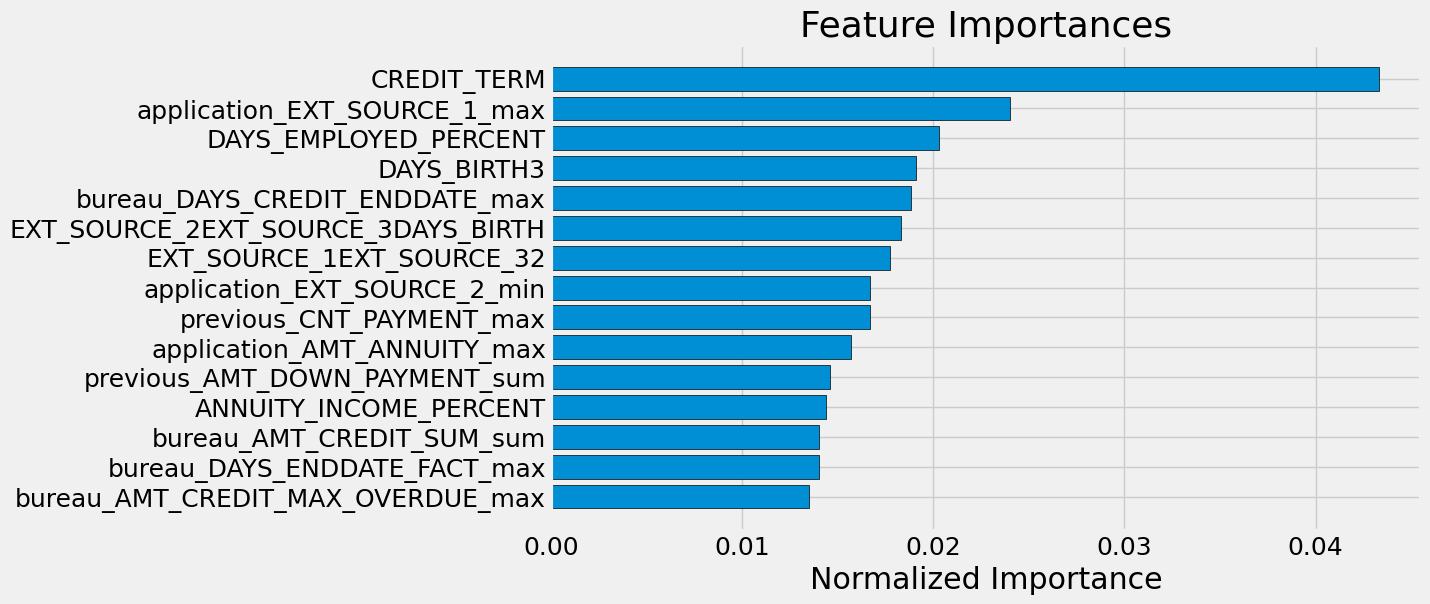

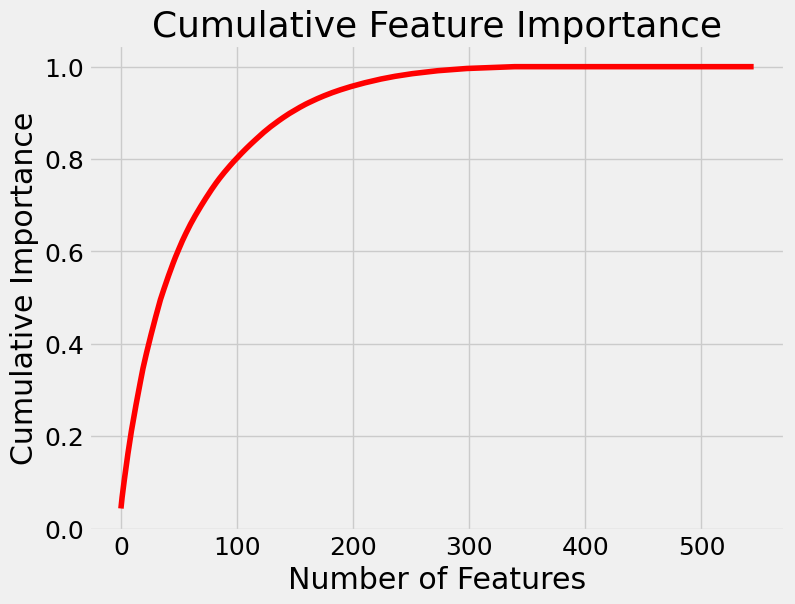

270 features required for 0.99 of cumulative importance


In [ ]:
norm_feature_importances = plot_feature_importances(feature_importances, threshold = 0.99)

In [ ]:
# récupère les zéros importances
no_importance = norm_feature_importances.loc[norm_feature_importances.importance == 0.0, 'feature']
print(no_importance.shape)

# supprime du train
train_previous_2 = train_previous_2.drop(no_importance, axis = 1)

(208,)


In [ ]:
def identify_zero_importance_features(train, train_labels, iterations = 2):
    """
    Identify zero importance features in a training dataset based on the
    feature importances from a gradient boosting model.

    Parameters
    --------
    train : dataframe
        Training features

    train_labels : np.array
        Labels for training data

    iterations : integer, default = 2
        Number of cross validation splits to use for determining feature importances
    """

    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(train.shape[1])

    # Create the model with several hyperparameters
    model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced', callbacks=([lgb.early_stopping(stopping_rounds=100)]))

    # Fit the model multiple times to avoid overfitting
    for i in tqdm(range(iterations)):

        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)

        # Train using early stopping
        model.fit(train_features, train_y, eval_set = [(valid_features, valid_y)], eval_metric = 'auc', callbacks=([lgb.early_stopping(stopping_rounds=100)]))

        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations

    feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    print(f'best auc score : {model.best_score_}')

    return zero_features, feature_importances

In [ ]:
second_round_zero_features, feature_importances = identify_zero_importance_features(train_previous_2, target_train)

  0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Warning] Unknown parameter: callbacks
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: 0x7dbda8978070>
[LightGBM] [Warning] Unknown parameter: object
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Unknown parameter: callbacks
[LightGBM] [Warning] Unknown parameter: 0x7dbda897b760>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: object
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 18734, number of negative: 211899
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.589154 seconds.
You ca

 50%|█████     | 1/2 [01:18<01:18, 78.57s/it]

Early stopping, best iteration is:
[178]	valid_0's auc: 0.778971	valid_0's binary_logloss: 0.522255
[LightGBM] [Warning] Unknown parameter: callbacks
[LightGBM] [Warning] Unknown parameter: 0x7dbda897bca0>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: object
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Unknown parameter: callbacks
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: object
[LightGBM] [Warning] Unknown parameter: 0x7dbda897af80>
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 18565, number of negative: 212068
[LightGBM]

100%|██████████| 2/2 [02:26<00:00, 73.40s/it]

Early stopping, best iteration is:
[155]	valid_0's auc: 0.778852	valid_0's binary_logloss: 0.527994

There are 0 features with 0.0 importance
best auc score : defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict([('auc', 0.7788524081823666), ('binary_logloss', 0.527993533958172)])})


In [ ]:
# gardons
norm_feature_importances.loc[norm_feature_importances.cumulative_importance <= 0.99, 'feature']

0                    application_DAYS_REGISTRATION_mean
1                      application_DAYS_ID_PUBLISH_mean
2                                 DAYS_EMPLOYED_PERCENT
3                                           CREDIT_TERM
4                                ANNUITY_INCOME_PERCENT
                             ...                       
293         previous_NAME_SELLER_INDUSTRY_Furniture_sum
294               previous_RATE_INTEREST_PRIVILEGED_max
295                   application_FLAG_DOCUMENT_18_mean
296    application_OCCUPATION_TYPE_LowskillLaborers_sum
297    previous_NAME_SELLER_INDUSTRY_Autotechnology_sum
Name: feature, Length: 298, dtype: object

In [ ]:
train_previous_2.shape

(307511, 338)

In [ ]:
# pour le moment nous avons bien reduit le nombre de colonne sans pour autant réduire la performance sur une baseline avec le lgmclassifier
# Nous allons aligner puis exporter ce traitement avant de continuer

print('Nombre de colonnes initial du test :', test_previous_2.shape[1])
train_previous_2, test_previous_2 = train_previous_2.align(test_previous_2, join = 'inner', axis = 1)
print('Nouveau nombre de colonnes du test :', test_previous_2.shape[1])

Nombre de colonnes initial du test : 547
Nouveau nombre de colonnes du test : 338


In [ ]:
# récupération des id et target pour les merges de la suite
train_previous_2['TARGET'] = target_train
train_previous_2['SK_ID_CURR'] = sk_id_train
test_previous_2['SK_ID_CURR'] = sk_id_test

In [ ]:
# export de ce traitement
train_previous_2.to_csv('FEATURE_ENG/train_previous_2_2.csv', index=False)
test_previous_2.to_csv('FEATURE_ENG/test_previous_2_2.csv', index=False)

# Applying to More Data

### Function to Aggregate Stats at the Client Level

In [ ]:
def aggregate_client(df, group_vars, df_names):
    """Aggregate a dataframe with data at the loan level
    at the client level

    Args:
        df (dataframe): data at the loan level
        group_vars (list of two strings): grouping variables for the loan
        and then the client (example ['SK_ID_PREV', 'SK_ID_CURR'])
        names (list of two strings): names to call the resulting columns
        (example ['cash', 'client'])

    Returns:
        df_client (dataframe): aggregated numeric stats at the client level.
        Each client will have a single row with all the numeric data aggregated
    """

    # Aggregate the numeric columns
    df_agg = agg_numeric(df, parent_var = group_vars[0], df_name = df_names[0])

    # If there are categorical variables
    if any(df.dtypes == 'category'):

        # Count the categorical columns
        df_counts = agg_categorical(df, parent_var = group_vars[0], df_name = df_names[0])

        # Merge the numeric and categorical
        df_by_loan = df_counts.merge(df_agg, on = group_vars[0], how = 'outer')

        gc.enable()
        del df_agg, df_counts
        gc.collect()

        # Merge to get the client id in dataframe
        df_by_loan = df_by_loan.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')

        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])

        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])


    # No categorical variables
    else:
        # Merge to get the client id in dataframe
        df_by_loan = df_agg.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')

        gc.enable()
        del df_agg
        gc.collect()

        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])

        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])

    # Memory management
    gc.enable()
    del df, df_by_loan
    gc.collect()

    return df_by_client

## Monthly Cash Data

In [ ]:
cash = pd.read_csv('POS_CASH_balance.csv')
cash = convert_types(cash, print_info=True)
#cash.head()

Original Memory Usage: 0.64 gb.
New Memory Usage: 0.29 gb.


In [ ]:
cash_by_client = aggregate_client(cash, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['cash', 'client'])
#cash_by_client.head()

In [ ]:
cash_by_client.shape

(337252, 162)

In [ ]:
# la ram a grimpée à 9 Gb...
gc.enable()
del cash
gc.collect()

0

In [ ]:
train_cash = train_previous_2.copy()
test_cash = test_previous_2.copy()

In [ ]:
train_cash = pd.read_csv('FEATURE_ENG/train_previous_2_2.csv')
test_cash = pd.read_csv('FEATURE_ENG/test_previous_2_2.csv')

In [ ]:
print('Cash by Client Shape: ', cash_by_client.shape)
train_cash = train_cash.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')
test_cash = test_cash.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del cash, cash_by_client
gc.collect()

In [ ]:
train_cash.shape

(307511, 502)

In [ ]:
# réduction des colonnes par valeurs manquantes
train_cash, test_cash = drop_missing_val_features(train_cash, test_cash, threshold=0.6)

2 columns have more than 0.6% of missing values in TRAIN dataset and are suppressed.
2 columns have more than 0.6% of missing values in TEST dataset and are suppressed.
Training new shape:  (307511, 500)
Testing new shape:  (48744, 499)


In [ ]:
corr_table, duo_to_drop = evaluate_colinear(train_cash, threshold=0.7)

100%|██████████| 180/180 [00:00<00:00, 3881.84it/s]

There are 133 columns to remove  among the 500 columns.


In [ ]:
# on supprime les duo corrélés
train_cash = train_cash.drop(duo_to_drop, axis=1)

In [ ]:
# vérifie l'importance de features

# récupération des id et target pour cohérence model
target_train = train_cash['TARGET']
sk_id_train = train_cash['SK_ID_CURR']
sk_id_test = test_cash['SK_ID_CURR']

train_cash = train_cash.drop(['TARGET'], axis=1)
train_cash = train_cash.drop(['SK_ID_CURR'], axis=1)
test_cash = test_cash.drop(['SK_ID_CURR'], axis=1)

zero_features_list, feature_importances_2 = identify_zero_importance_features(train_cash, target_train)

In [ ]:
zero_features_list, feature_importances_2 = identify_zero_importance_features(train_cash, target_train)

  0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Warning] Unknown parameter: callbacks
[LightGBM] [Warning] Unknown parameter: object
[LightGBM] [Warning] Unknown parameter: 0x7d5037366b60>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: callbacks
[LightGBM] [Warning] Unknown parameter: 0x7d5037367ee0>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: object
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 18734, number of negative: 211899
[LightGBM] [Info] Auto-choosin

 50%|█████     | 1/2 [01:13<01:13, 73.36s/it]

Early stopping, best iteration is:
[160]	valid_0's auc: 0.776847	valid_0's binary_logloss: 0.528468
[LightGBM] [Warning] Unknown parameter: callbacks
[LightGBM] [Warning] Unknown parameter: 0x7d50373aff10>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: object
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: callbacks
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: object
[LightGBM] [Warning] Unknown parameter: 0x7d50373ad750>
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[L

100%|██████████| 2/2 [02:28<00:00, 74.35s/it]

Early stopping, best iteration is:
[155]	valid_0's auc: 0.778049	valid_0's binary_logloss: 0.528869

There are 43 features with 0.0 importance
best auc score : defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict([('auc', 0.7780487593013827), ('binary_logloss', 0.5288685964931873)])})


In [ ]:
# supprimons les features sans importance selon le model
train_cash = train_cash.drop(zero_features_list, axis=1)

In [ ]:
print(train_cash.shape)

(307511, 322)


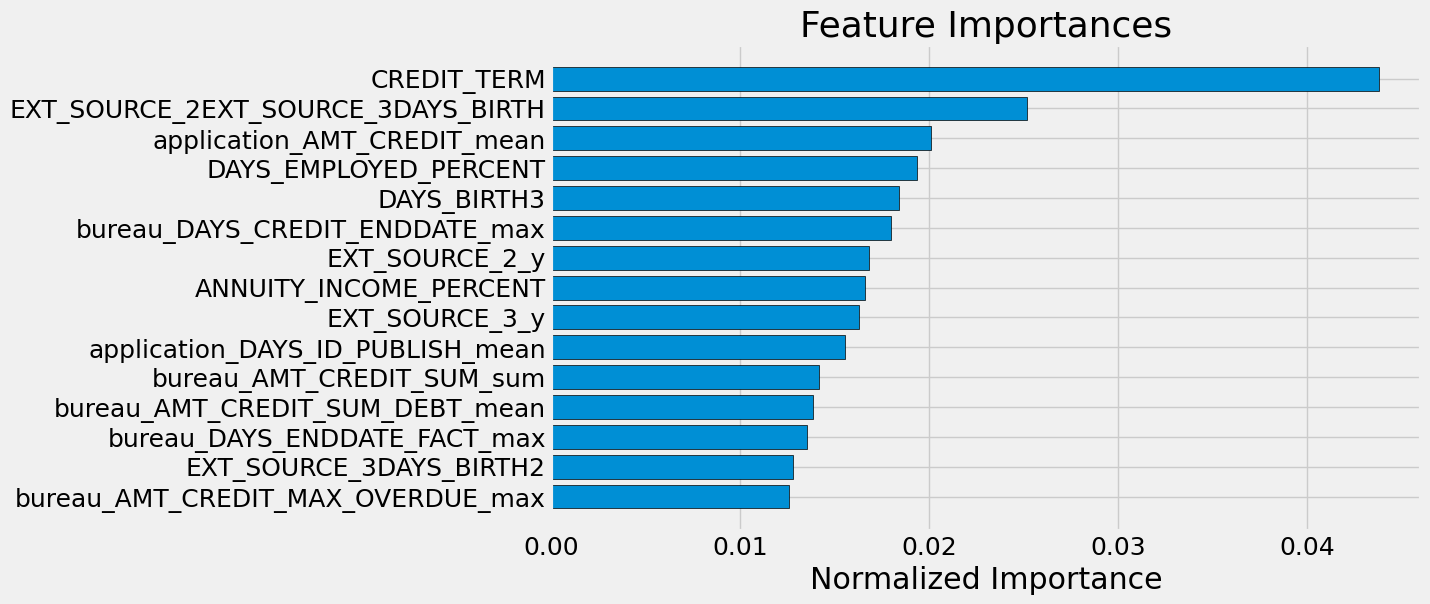

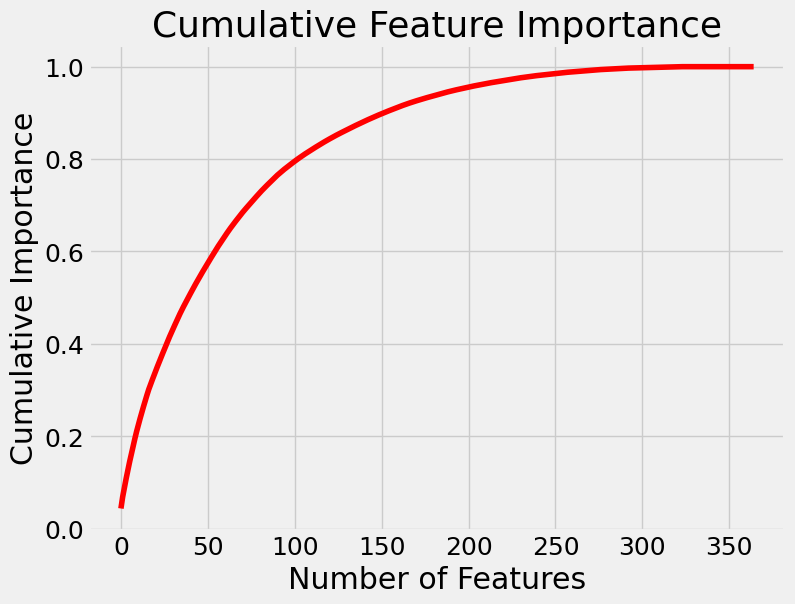

265 features required for 0.99 of cumulative importance


In [ ]:
norm_feature_importances_2 = plot_feature_importances(feature_importances_2, threshold = 0.99)

In [ ]:
# avec 322 features c'est ok pour la suite
train_cash, test_cash = train_cash.align(test_cash, join = 'inner', axis = 1)

In [ ]:
# récupération des id et target pour les merges de la suite
train_cash['TARGET'] = target_train
train_cash['SK_ID_CURR'] = sk_id_train
test_cash['SK_ID_CURR'] = sk_id_test

print(train_cash.shape)
print(test_cash.shape)

(307511, 324)
(48744, 323)


In [ ]:
# export de cette étape
train_cash.to_csv('FEATURE_ENG/train_cash.csv', index=False)
test_cash.to_csv('FEATURE_ENG/test_cash.csv', index=False)

## Monthly Credit Data

In [ ]:
credit = pd.read_csv('credit_card_balance.csv')
credit = convert_types(credit, print_info = True)
credit.head()

Original Memory Usage: 0.71 gb.
New Memory Usage: 0.34 gb.


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,...,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,...,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,...,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,...,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,...,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0


In [ ]:
credit_by_client = aggregate_client(credit, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['credit', 'client'])
credit_by_client.head()

,client_credit_MONTHS_BALANCE_sum_sum,client_credit_MONTHS_BALANCE_min_sum,client_credit_MONTHS_BALANCE_mean_sum,client_credit_MONTHS_BALANCE_sum_min,client_credit_MONTHS_BALANCE_sum_mean,client_credit_MONTHS_BALANCE_sum_max,client_credit_MONTHS_BALANCE_max_sum,client_credit_MONTHS_BALANCE_min_min,client_credit_MONTHS_BALANCE_min_mean,client_credit_MONTHS_BALANCE_min_max,...,client_credit_AMT_DRAWINGS_ATM_CURRENT_mean_max,client_credit_AMT_PAYMENT_CURRENT_mean_mean,client_credit_AMT_PAYMENT_CURRENT_mean_min,client_credit_AMT_PAYMENT_CURRENT_mean_max,client_credit_AMT_PAYMENT_CURRENT_max_mean,client_credit_AMT_PAYMENT_CURRENT_max_min,client_credit_AMT_PAYMENT_CURRENT_max_max,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_min,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_mean,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_max
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,-126,-36,-21.0,-21,-21.0,-21,-6,-6,-6.0,-6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100011,-210826,-5550,-2849.0,-2849,-2849.0,-2849,-148,-75,-75.0,-75,...,2432.432373,4843.063965,4843.063965,4843.063965,55485.0,55485.0,55485.0,180000.0,180000.0,180000.0
100013,-446976,-9216,-4656.0,-4656,-4656.0,-4656,-96,-96,-96.0,-96,...,6350.000000,7168.346191,7168.346191,7168.346191,153675.0,153675.0,153675.0,157500.0,157500.0,157500.0
100021,-2890,-306,-170.0,-170,-170.0,-170,-34,-18,-18.0,-18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100023,-480,-88,-60.0,-60,-60.0,-60,-32,-11,-11.0,-11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print('Credit by client shape: ', credit_by_client.shape)

train_credit = train_cash.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')
test_credit = test_cash.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')

Credit by client shape:  (103558, 376)


In [ ]:
gc.enable()
del credit, credit_by_client
gc.collect()

0

In [ ]:
# réduction des colonnes par valeurs manquantes
train_credit, test_credit = drop_missing_val_features(train_credit, test_credit, threshold=0.75)

63 columns have more than 0.75% of missing values in TRAIN dataset and are suppressed.
63 columns have more than 0.75% of missing values in TEST dataset and are suppressed.
Training new shape:  (307511, 637)
Testing new shape:  (48744, 636)


In [ ]:
corr_table, duo_to_drop = evaluate_colinear(train_credit, threshold=0.7)

100%|██████████| 317/317 [00:00<00:00, 2630.85it/s]

There are 221 columns to remove  among the 637 columns.


In [ ]:
# on supprime les duo corrélés
train_credit = train_credit.drop(duo_to_drop, axis=1)

In [ ]:
train_credit.shape

(307511, 416)

In [ ]:
# export de cette étape
train_credit.to_csv('FEATURE_ENG/train_credit.csv', index=False)
test_credit.to_csv('FEATURE_ENG/test_credit.csv', index=False)

In [ ]:
# vérifie l'importance de features

# récupération des id et target pour cohérence model
target_train = train_credit['TARGET']
sk_id_train = train_credit['SK_ID_CURR']
sk_id_test = test_credit['SK_ID_CURR']

train_credit = train_credit.drop(['TARGET'], axis=1)
train_credit = train_credit.drop(['SK_ID_CURR'], axis=1)
test_credit = test_credit.drop(['SK_ID_CURR'], axis=1)

zero_features_list, feature_importances_2 = identify_zero_importance_features(train_credit, target_train)

  0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Warning] Unknown parameter: callbacks
[LightGBM] [Warning] Unknown parameter: 0x7d5036e300a0>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: object
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: callbacks
[LightGBM] [Warning] Unknown parameter: 0x7d5036e33640>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: object
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 18734, number of negative: 211899
[LightGBM] [Info] Auto-choosin

 50%|█████     | 1/2 [01:36<01:36, 96.37s/it]

Early stopping, best iteration is:
[156]	valid_0's auc: 0.778071	valid_0's binary_logloss: 0.526769
[LightGBM] [Warning] Unknown parameter: callbacks
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: object
[LightGBM] [Warning] Unknown parameter: 0x7d5036e33460>
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: callbacks
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: object
[LightGBM] [Warning] Unknown parameter: 0x7d5036e30340>
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[L

100%|██████████| 2/2 [03:02<00:00, 91.28s/it]

Early stopping, best iteration is:
[120]	valid_0's auc: 0.77927	valid_0's binary_logloss: 0.53676

There are 34 features with 0.0 importance
best auc score : defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict([('auc', 0.7792701781089761), ('binary_logloss', 0.536760024619934)])})


In [ ]:
# supprimons les features sans importance selon le model
train_credit = train_credit.drop(zero_features_list, axis=1)

In [ ]:
print(train_credit.shape)

(307511, 380)


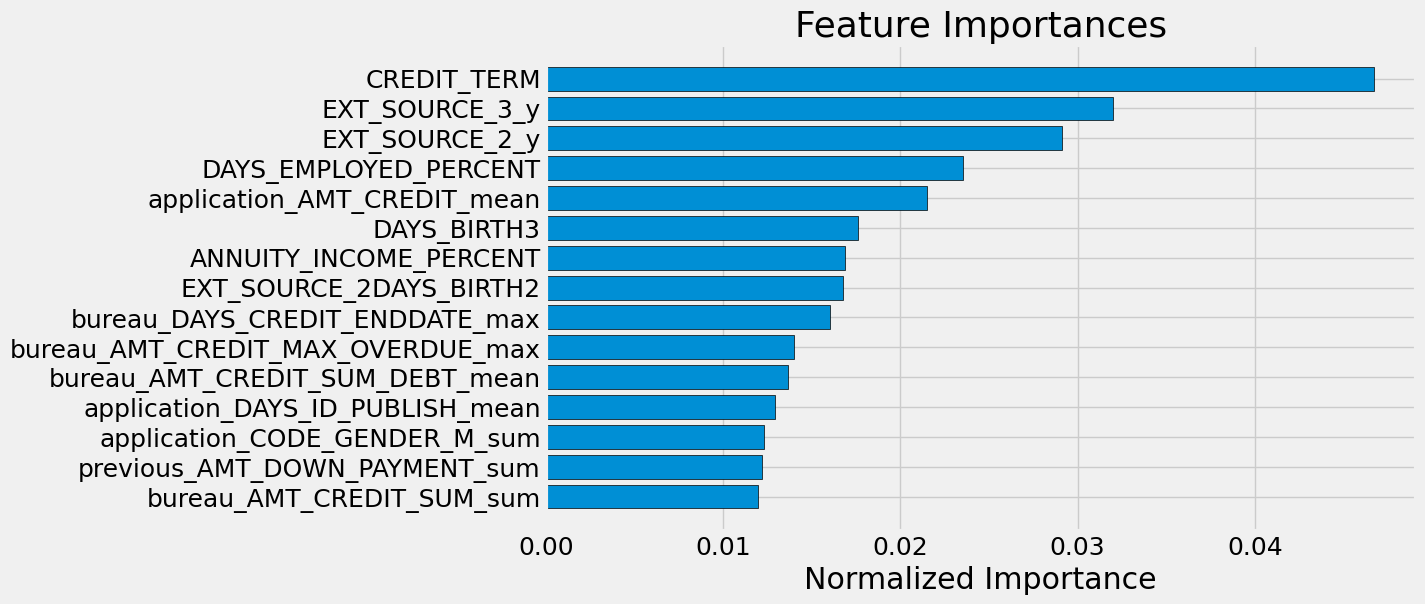

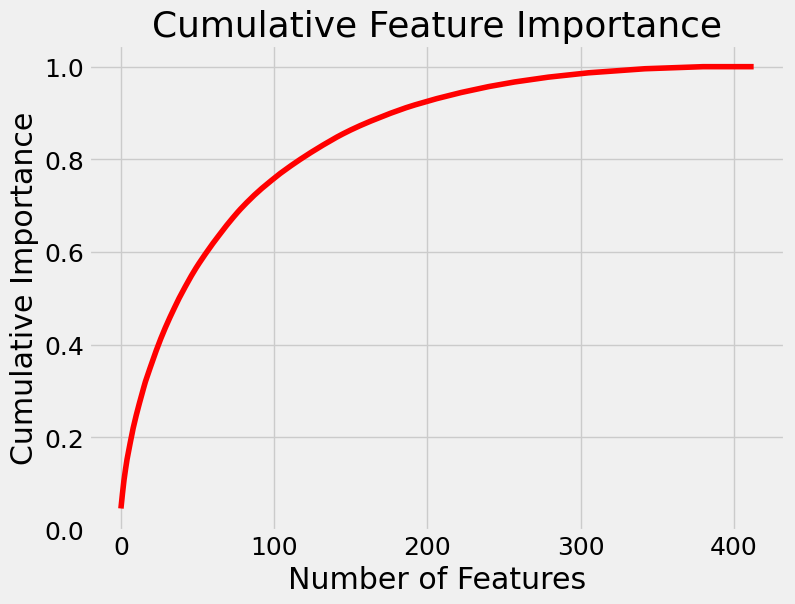

320 features required for 0.99 of cumulative importance


In [ ]:
norm_feature_importances_2 = plot_feature_importances(feature_importances_2, threshold = 0.99)

In [ ]:
# avec 380 features c'est ok pour la suite
train_credit, test_credit = train_credit.align(test_credit, join = 'inner', axis = 1)

In [ ]:
# récupération des id et target pour les merges de la suite
train_credit['TARGET'] = target_train
train_credit['SK_ID_CURR'] = sk_id_train
test_credit['SK_ID_CURR'] = sk_id_test

print(train_credit.shape)
print(test_credit.shape)

(307511, 382)
(48744, 381)


In [ ]:
# export de cette étape
train_credit.to_csv('FEATURE_ENG/train_credit.csv', index=False)
test_credit.to_csv('FEATURE_ENG/test_credit.csv', index=False)

### Installment Payments

In [ ]:
installments = pd.read_csv('installments_payments.csv')
installments = convert_types(installments, print_info = True)
installments.head()

Original Memory Usage: 0.87 gb.
New Memory Usage: 0.44 gb.


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961


In [ ]:
installments_by_client = aggregate_client(installments, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['installments', 'client'])
installments_by_client.head()

,client_installments_DAYS_ENTRY_PAYMENT_sum_sum,client_installments_DAYS_INSTALMENT_sum_sum,client_installments_DAYS_ENTRY_PAYMENT_min_sum,client_installments_DAYS_INSTALMENT_min_sum,client_installments_DAYS_ENTRY_PAYMENT_mean_sum,client_installments_DAYS_INSTALMENT_mean_sum,client_installments_DAYS_ENTRY_PAYMENT_max_sum,client_installments_DAYS_INSTALMENT_max_sum,client_installments_DAYS_INSTALMENT_sum_min,client_installments_DAYS_ENTRY_PAYMENT_sum_min,...,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_INSTALMENT_min_sum,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_INSTALMENT_sum_max,client_installments_AMT_PAYMENT_mean_sum,client_installments_AMT_INSTALMENT_mean_sum,client_installments_AMT_INSTALMENT_max_sum,client_installments_AMT_PAYMENT_max_sum,client_installments_AMT_PAYMENT_sum_sum,client_installments_AMT_INSTALMENT_sum_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-52813.0,-52598.0,-15608.0,-15584.0,-15365.0,-15314.0,-15080.0,-15044.0,-8658.0,-8647.0,...,2.774678e+04,2.774678e+04,2.925090e+04,2.925090e+04,4.119593e+04,4.119593e+04,8.153775e+04,8.153775e+04,1.528387e+05,1.528387e+05
100002,-113867.0,-106495.0,-11153.0,-10735.0,-5993.0,-5605.0,-931.0,-475.0,-5605.0,-5993.0,...,1.757837e+05,1.757837e+05,2.196257e+05,2.196257e+05,2.196257e+05,2.196257e+05,1.008781e+06,1.008781e+06,4.172888e+06,4.172888e+06
100003,-367137.0,-365546.0,-37757.0,-37514.0,-34633.0,-34454.0,-31594.0,-31394.0,-25740.0,-25821.0,...,1.154108e+06,1.154108e+06,1.150977e+06,1.150977e+06,1.618865e+06,1.618865e+06,4.394102e+06,4.394102e+06,1.134881e+07,1.134881e+07
100004,-6855.0,-6786.0,-2385.0,-2352.0,-2285.0,-2262.0,-2181.0,-2172.0,-2262.0,-2285.0,...,1.607175e+04,1.607175e+04,2.128846e+04,2.128846e+04,2.128846e+04,2.128846e+04,3.172189e+04,3.172189e+04,6.386539e+04,6.386539e+04
100005,-49374.0,-47466.0,-6624.0,-6354.0,-5486.0,-5274.0,-4230.0,-4194.0,-5274.0,-5486.0,...,4.331880e+04,4.331880e+04,5.616184e+04,5.616184e+04,5.616184e+04,5.616184e+04,1.589062e+05,1.589062e+05,5.054566e+05,5.054566e+05


In [ ]:
print('Installments by client shape: ', installments_by_client.shape)

train_complete = train_credit.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')
test_complete = test_credit.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')

Installments by client shape:  (339587, 106)


In [ ]:
gc.enable()
del installments, installments_by_client
gc.collect()

0

In [ ]:
# réduction des colonnes par valeurs manquantes
train_complete, test_complete = drop_missing_val_features(train_complete, test_complete, threshold=0.75)

0 columns have more than 0.75% of missing values in TRAIN dataset and are suppressed.
0 columns have more than 0.75% of missing values in TEST dataset and are suppressed.
Training new shape:  (307511, 488)
Testing new shape:  (48744, 487)


In [ ]:
corr_table, duo_to_drop = evaluate_colinear(train_complete, threshold=0.8)

100%|██████████| 153/153 [00:00<00:00, 3257.06it/s]

There are 110 columns to remove  among the 488 columns.


In [ ]:
# on supprime les duo corrélés
train_complete = train_complete.drop(duo_to_drop, axis=1)

In [ ]:
# vérifie l'importance de features
# récupération des id et target pour cohérence model
target_train = train_complete['TARGET']
sk_id_train = train_complete['SK_ID_CURR']
sk_id_test = test_complete['SK_ID_CURR']
train_complete = train_complete.drop(['TARGET'], axis=1)
train_complete = train_complete.drop(['SK_ID_CURR'], axis=1)
test_complete = test_complete.drop(['SK_ID_CURR'], axis=1)
zero_features_list, feature_importances_2 = identify_zero_importance_features(train_complete, target_train)

  0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Warning] Unknown parameter: callbacks
[LightGBM] [Warning] Unknown parameter: 0x7d505f416770>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: object
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: callbacks
[LightGBM] [Warning] Unknown parameter: 0x7d505f417340>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: object
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 18734, number of negative: 211899
[LightGBM] [Info] Auto-choosin

 50%|█████     | 1/2 [02:10<02:10, 130.08s/it]

Early stopping, best iteration is:
[160]	valid_0's auc: 0.780879	valid_0's binary_logloss: 0.523572
[LightGBM] [Warning] Unknown parameter: callbacks
[LightGBM] [Warning] Unknown parameter: 0x7d505f417a90>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: object
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: callbacks
[LightGBM] [Warning] Unknown parameter: 0x7d505f4147f0>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: object
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[L

100%|██████████| 2/2 [03:31<00:00, 105.58s/it]

Early stopping, best iteration is:
[138]	valid_0's auc: 0.78145	valid_0's binary_logloss: 0.529429

There are 25 features with 0.0 importance
best auc score : defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict([('auc', 0.7814500678944276), ('binary_logloss', 0.5294287826087704)])})


In [ ]:
# supprimons les features sans importance selon le model
train_complete = train_complete.drop(zero_features_list, axis=1)

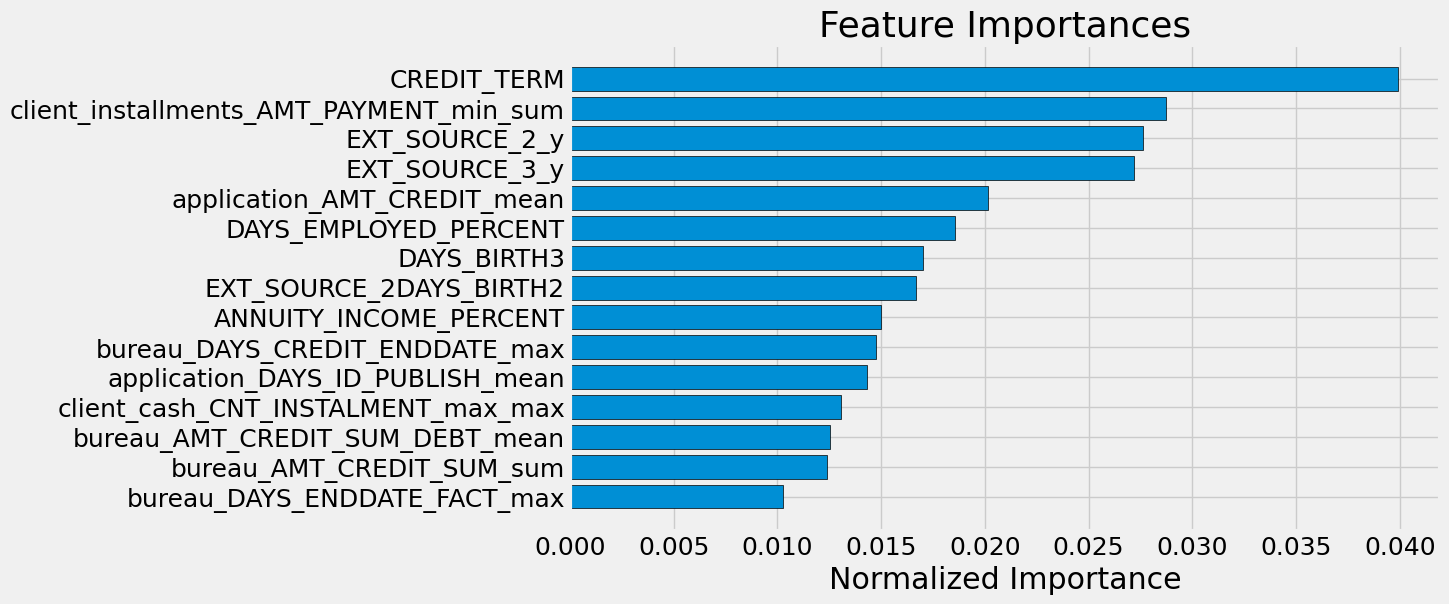

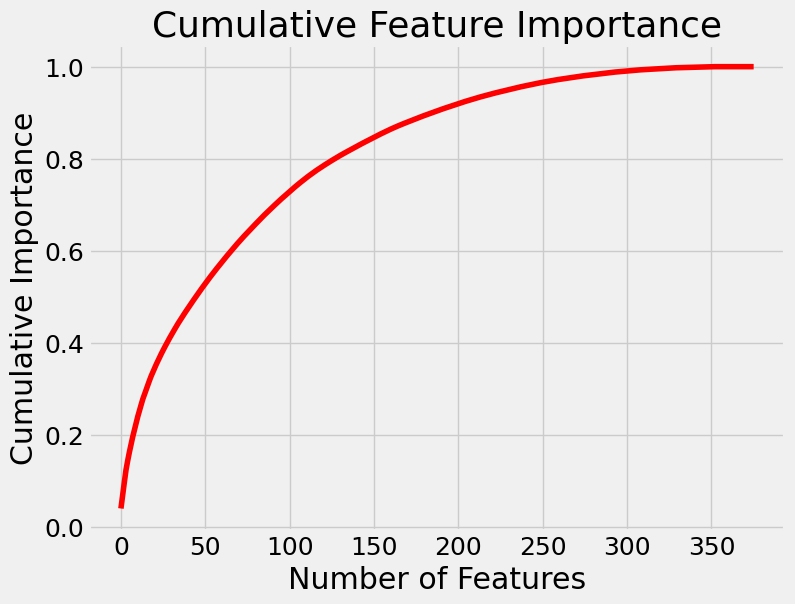

299 features required for 0.99 of cumulative importance


In [ ]:
norm_feature_importances_2 = plot_feature_importances(feature_importances_2, threshold = 0.99)

In [ ]:
train_complete.shape

(307511, 351)

In [ ]:
# avec 351 features c'est ok pour la suite
train_complete, test_complete = train_complete.align(test_complete, join = 'inner', axis = 1)

In [ ]:
# récupération des id et target pour les merges de la suite
train_complete['TARGET'] = target_train
train_complete['SK_ID_CURR'] = sk_id_train
test_complete['SK_ID_CURR'] = sk_id_test

print(train_complete.shape)
print(test_complete.shape)

# export de cette étape
train_complete.to_csv('FEATURE_ENG/train_complete.csv', index=False)
test_complete.to_csv('FEATURE_ENG/test_complete.csv', index=False)

(307511, 353)
(48744, 352)


In [ ]:
print('Final Training Shape: ', train_complete.shape)
print('Final Testing Shape: ', test_complete.shape)

Final Training Shape:  (307511, 353)
Final Testing Shape:  (48744, 352)


In [ ]:
print(f'Final training size: {return_size(train_complete)}')
print(f'Final testing size: {return_size(test_complete)}')

Final training size: 0.77
Final testing size: 0.12


## Modeling

In [ ]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):

    """Train and test a light gradient boosting model using
    cross validation.

    Parameters
    --------
        features (pd.DataFrame):
            dataframe of training features to use
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame):
            dataframe of testing features to use
            for making predictions with the model.
        encoding (str, default = 'ohe'):
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation

    Return
    --------
        submission (pd.DataFrame):
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame):
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame):
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.

    """

    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']

    # Extract the labels for training
    labels = features['TARGET']

    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])


    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)

        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)

        # No categorical indices to record
        cat_indices = 'auto'

    # Integer label encoding
    elif encoding == 'le':

        # Create a label encoder
        label_encoder = LabelEncoder()

        # List for storing categorical indices
        cat_indices = []

        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)

    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")

    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)

    # Extract feature names
    feature_names = list(features.columns)

    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)

    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)

    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))

    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])

    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])

    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []

    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):

        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]

        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary',
                                   class_weight = 'balanced', learning_rate = 0.05,
                                   reg_alpha = 0.1, reg_lambda = 0.1,
                                   subsample = 0.8, n_jobs = -1, random_state = 50)

        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)

        # Record the best iteration
        best_iteration = model.best_iteration_

        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits

        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits

        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]

        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']

        valid_scores.append(valid_score)
        train_scores.append(train_score)

        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()

    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})

    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)

    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))

    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')

    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores})

    return submission, feature_importances, metrics

In [ ]:
submission, fi, metrics = model(features, test_features)

In [ ]:
metrics

In [ ]:
submission.to_csv('submission_manualp2.csv', index = False)